In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import combinations
from collections import defaultdict
from sklearn import metrics
import re
import gensim

%matplotlib inline
import matplotlib.pyplot as plt

SEED = 42

C:\Users\Андрей\Anaconda3\envs\python36\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# show topic descriptors
def get_descriptor( terms, H, topic_index, top ):
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

def get_all_descriptors(k, H, terms, top):
    for topic_index in range(k):
        descriptor = get_descriptor( terms, H, topic_index, top )
        str_descriptor = ", ".join( descriptor )
        print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

In [3]:
class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens

In [4]:
def inv_index(docs):
    counts = defaultdict(set)
    for i,doc in enumerate(docs):
        for token in doc:
            counts[token].add(i)
    return counts, i+1

In [5]:
def tc_w2c( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

def calculate_tc_w2c(topic_models, w2v_model):
    k_values = []
    coherences = []
    for (k,W,H) in topic_models:
        # Get all of the topic descriptors - the term_rankings, based on top 20 terms
        term_rankings = []
        for topic_index in range(k):
            term_rankings.append( get_descriptor( terms, H, topic_index, 20 ) )
        # Now calculate the coherence based on our Word2vec model
        k_values.append( k )
        coherences.append( tc_w2c( w2v_model, term_rankings ) )
        #print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )
    return k_values, coherences

In [6]:
def uci(inv_index, total, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            bi_prob = len(inv_index[pair[0]] & inv_index[pair[1]]) / total
            first_prob = len(inv_index[pair[0]]) / total
            second_prob = len(inv_index[pair[1]]) / total
            score = np.log((bi_prob + pow(10,-12)) / (first_prob * second_prob)) 
                                      # small constant to avoid bi_prob = 0
            pair_scores.append(score)
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) * (2 / (len(term_rankings[topic_index]) * (len(term_rankings[topic_index])-1)))
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

def calculate_uci(topic_models, inv_index, total):
    k_values = []
    coherences = []
    for (k,W,H) in topic_models:
        # Get all of the topic descriptors - the term_rankings, based on top 20 terms
        term_rankings = []
        for topic_index in range(k):
            term_rankings.append( get_descriptor( terms, H, topic_index, 20 ) )
        # Now calculate the coherence based on our Word2vec model
        k_values.append( k )
        coherences.append( uci(inv_index, total, term_rankings) )
        #print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )
    return k_values, coherences

In [7]:
def umass(inv_index, total, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            bi_prob = len(inv_index[pair[0]] & inv_index[pair[1]]) / total
            first_prob = len(inv_index[pair[0]]) / total
            score = np.log((bi_prob + pow(10,-12)) /  first_prob) 
                                      # small constant to avoid bi_prob = 0
            pair_scores.append(score)
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) * (2 / (len(term_rankings[topic_index]) * (len(term_rankings[topic_index])-1)))
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

def calculate_umass(topic_models, inv_index, total):
    k_values = []
    coherences = []
    for (k,W,H) in topic_models:
        # Get all of the topic descriptors - the term_rankings, based on top 20 terms
        term_rankings = []
        for topic_index in range(k):
            term_rankings.append( get_descriptor( terms, H, topic_index, 20 ) )
        # Now calculate the coherence based on our Word2vec model
        k_values.append( k )
        coherences.append( umass(inv_index, total, term_rankings) )
        #print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )
    return k_values, coherences

In [8]:
def plot_coherence(k_values, coherences):
    fig = plt.figure(figsize=(13,7))
    # create the line plot
    ax = plt.plot( k_values, coherences )
    plt.xticks(k_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Mean Coherence")
    # add the points
    plt.scatter( k_values, coherences, s=120)
    # find and annotate the maximum point on the plot
    ymax = max(coherences)
    xpos = coherences.index(ymax)
    best_k = k_values[xpos]
    plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
    # show the plot
    plt.show()
    return best_k

In [9]:
news = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), random_state=SEED)
data = news['data']

In [10]:
kmin, kmax = 5, 40

# Preprocess data

In [11]:
data_lower = [x.lower() for x in data]

In [12]:
# custom stopwords
custom_stop_words = []
with open( "stopwords.txt", "r" ) as f:
    for line in f.readlines():
        custom_stop_words.append( line.strip().lower() )

In [13]:
vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 20)
A = vectorizer.fit_transform(data_lower)
terms = vectorizer.get_feature_names()

In [14]:
docgen = TokenGenerator( data_lower, custom_stop_words )
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)

In [15]:
idx,total = inv_index(docgen) # inverse index and total count of docs

# NMF

In [16]:
topic_models_nmf = []
for k in range(kmin,kmax+1):
    model = NMF( init="nndsvd", n_components=k, random_state=SEED ) 
    W = model.fit_transform( A ) # тексты с вероятностями быть по одной из тем
    H = model.components_  # темы с вероятностями слов быть по ним
    topic_models_nmf.append( (k,W,H) )

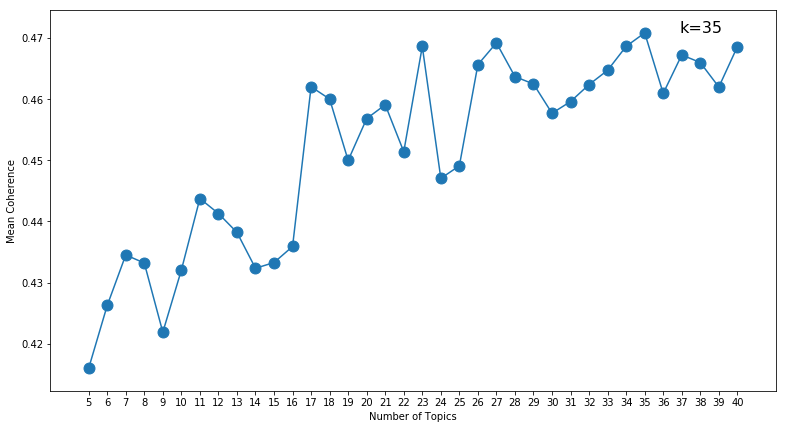

In [17]:
k_values_tc_w2c, coherences_tc_w2c = calculate_tc_w2c(topic_models_nmf, w2v_model)
best_k_nmf_w2c = plot_coherence(k_values_tc_w2c, coherences_tc_w2c)

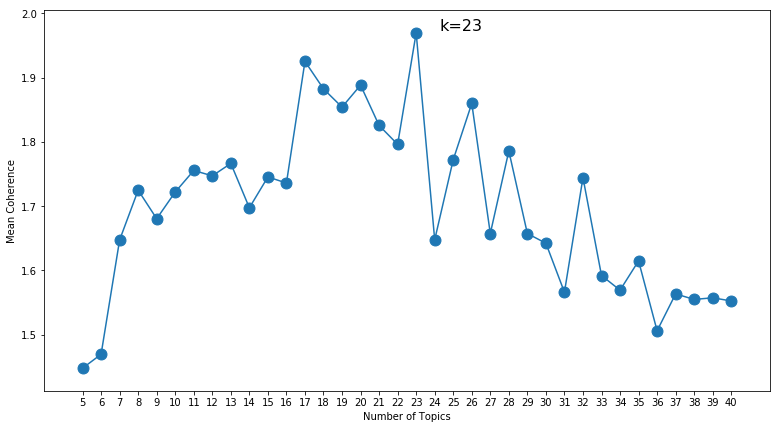

In [18]:
k_values_uci, coherences_uci = calculate_uci(topic_models_nmf, idx, total)
best_k_nmf_uci = plot_coherence(k_values_uci, coherences_uci)

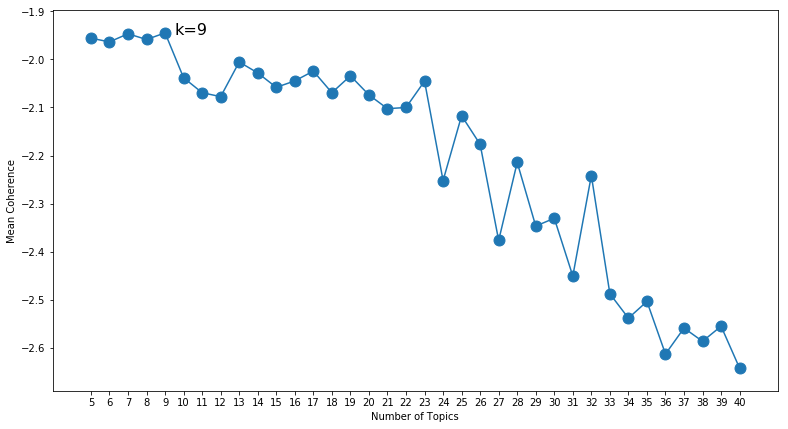

In [19]:
k_values_umass, coherences_umass = calculate_umass(topic_models_nmf, idx, total)
best_k_nmf_umass = plot_coherence(k_values_umass, coherences_umass)

# LDA

In [20]:
topic_models_lda = []
for k in range(kmin,kmax+1):
    model = LatentDirichletAllocation(n_components=k, learning_method='batch', random_state=SEED)
    W = model.fit_transform( A )
    H = model.components_    
    topic_models_lda.append( (k,W,H) )

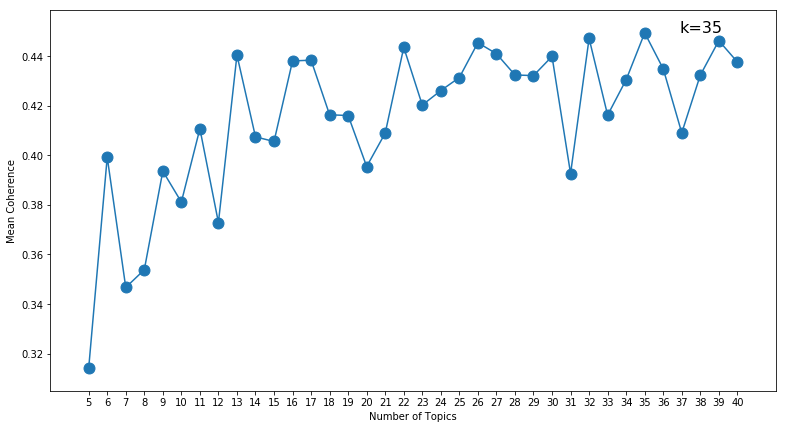

In [21]:
k_values_tc_w2c, coherences_tc_w2c = calculate_tc_w2c(topic_models_lda, w2v_model)
best_k_lda_w2c = plot_coherence(k_values_tc_w2c, coherences_tc_w2c)

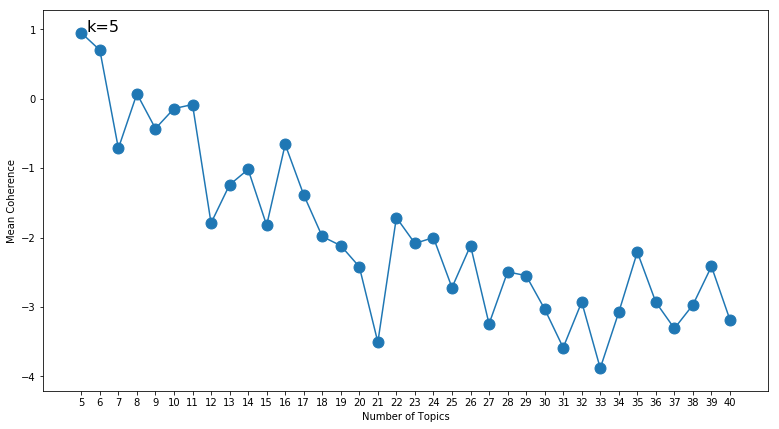

In [22]:
k_values_uci, coherences_uci = calculate_uci(topic_models_lda, idx, total)
best_k_lda_uci = plot_coherence(k_values_uci, coherences_uci)

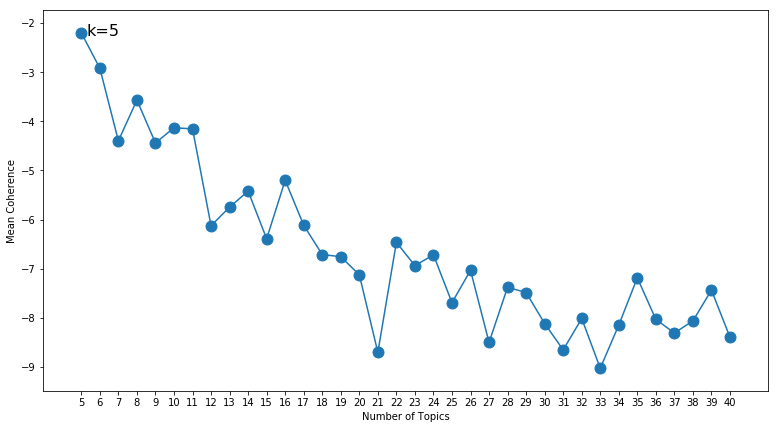

In [23]:
k_values_umass, coherences_umass = calculate_umass(topic_models_lda, idx, total)
best_k_lda_umass = plot_coherence(k_values_umass, coherences_umass)

# LSA

In [24]:
topic_models_lsa = []
for k in range(kmin,kmax+1):
    model = TruncatedSVD(n_components=k,random_state=SEED ) 
    W = model.fit_transform( A )
    H = model.components_    
    topic_models_lsa.append( (k,W,H) )

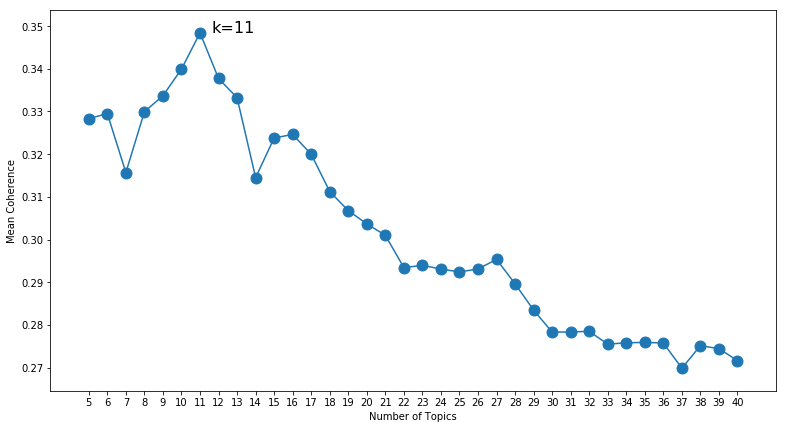

In [25]:
k_values_tc_w2c, coherences_tc_w2c = calculate_tc_w2c(topic_models_lsa, w2v_model)
best_k_lsa_w2c = plot_coherence(k_values_tc_w2c, coherences_tc_w2c)

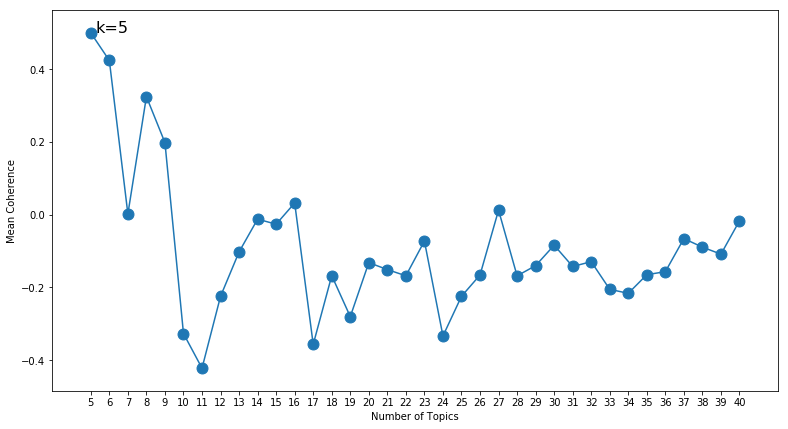

In [26]:
k_values_uci, coherences_uci = calculate_uci(topic_models_lsa, idx, total)
best_k_lsa_uci = plot_coherence(k_values_uci, coherences_uci)

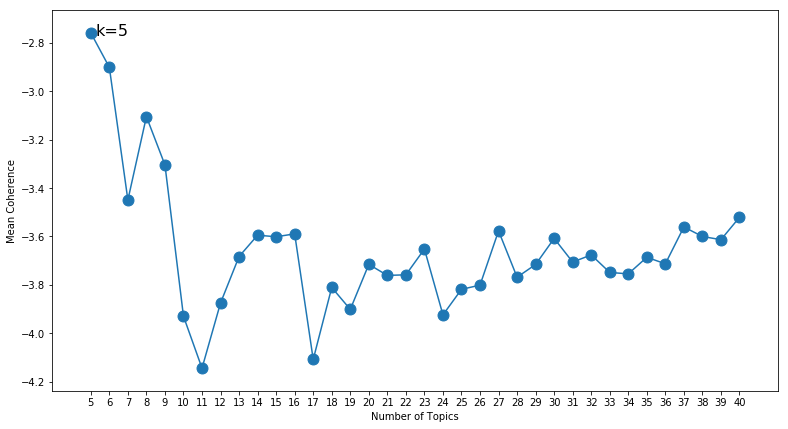

In [27]:
k_values_umass, coherences_umass = calculate_umass(topic_models_lsa, idx, total)
best_k_lsa_umass = plot_coherence(k_values_umass, coherences_umass)

Результаты какие-то странные (мне не нравятся UCI и UMass для LDA и LSA), но по всем метрикам лидирует NMF, а в этой модели мне больше всего нравится метрика UCI, так как количество тем по ней совпадает с изначальным. Посмотрим дескрипторы по разному количеству тем, определенному метриками.
# NMF - дескрипторы
## Темы в датасете

In [28]:
print('\n'.join(news.target_names))

alt.atheism
comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x
misc.forsale
rec.autos
rec.motorcycles
rec.sport.baseball
rec.sport.hockey
sci.crypt
sci.electronics
sci.med
sci.space
soc.religion.christian
talk.politics.guns
talk.politics.mideast
talk.politics.misc
talk.religion.misc


## w2c

In [29]:
k = best_k_nmf_w2c
H = topic_models_nmf[k-kmin][2]

get_all_descriptors(k, H, terms, 10)

Topic 01: time, see, something, really, go, way, going, long, sure, back
Topic 02: system, mac, problem, apple, modem, monitor, port, memory, power, computer
Topic 03: god, believe, existence, lord, hell, faith, belief, sin, atheism, exist
Topic 04: drive, hard, disk, drives, floppy, ide, controller, cd, meg, boot
Topic 05: please, email, post, someone, interested, reply, looking, tell, thank, send
Topic 06: team, players, season, player, teams, play, nhl, win, hockey, league
Topic 07: 10, 11, 12, 15, 16, 25, 14, 20, 13, 17
Topic 08: geb, dsl, cadre, n3jxp, chastity, pitt, skepticism, intellect, shameful, surrender
Topic 09: key, chip, clipper, encryption, keys, escrow, algorithm, phone, des, nsa
Topic 10: game, games, espn, baseball, hockey, night, pens, series, fans, caps
Topic 11: card, video, monitor, cards, drivers, vga, bus, driver, color, ati
Topic 12: windows, dos, os, run, nt, version, running, microsoft, apps, drivers
Topic 13: fbi, koresh, batf, fire, children, compound, gas

Темы 1, 7, 8, 13, 16 выглядят мусорными. Тем слишком много, хоть почти все и имеют право на жизнь.
## UCI

In [30]:
k = best_k_nmf_uci
H = topic_models_nmf[k-kmin][2]

get_all_descriptors(k, H, terms, 10)

Topic 01: know, good, time, really, something, go, see, sure, thing, going
Topic 02: space, nasa, shuttle, launch, orbit, earth, system, data, moon, science
Topic 03: god, jesus, bible, christ, believe, faith, christian, sin, christians, lord
Topic 04: drive, scsi, ide, disk, drives, hard, controller, floppy, hd, seagate
Topic 05: thanks, please, mail, advance, know, hi, looking, email, info, information
Topic 06: game, games, team, hockey, baseball, players, play, season, espn, win
Topic 07: sale, mac, software, offer, price, modem, apple, shipping, condition, printer
Topic 08: geb, dsl, cadre, n3jxp, chastity, pitt, skepticism, intellect, shameful, surrender
Topic 09: key, chip, clipper, encryption, keys, escrow, system, algorithm, phone, des
Topic 10: government, gun, right, law, rights, guns, state, laws, control, police
Topic 11: card, video, monitor, bus, cards, vga, drivers, driver, bit, color
Topic 12: windows, dos, os, run, nt, version, running, microsoft, system, mouse
Topic 

1, 8, 14, 16, 20 - мусорные. Но тем меньше, они более глобальные.
## UMass

In [31]:
k = best_k_nmf_umass
H = topic_models_nmf[k-kmin][2]

get_all_descriptors(k, H, terms, 10)

Topic 01: people, think, get, right, know, time, see, way, good, want
Topic 02: windows, file, dos, program, files, window, version, problem, run, running
Topic 03: god, jesus, bible, christ, believe, christian, faith, christians, sin, church
Topic 04: drive, scsi, disk, ide, hard, card, drives, controller, bus, floppy
Topic 05: thanks, please, mail, know, advance, email, looking, hi, info, address
Topic 06: game, games, team, hockey, baseball, players, play, season, win, espn
Topic 07: 00, car, 10, sale, price, 50, 20, offer, shipping, 15
Topic 08: edu, geb, dsl, n3jxp, cadre, chastity, pitt, skepticism, intellect, shameful
Topic 09: key, chip, clipper, encryption, keys, government, system, escrow, phone, algorithm


1 и 8 - мусорные. Некоторые важные темы потеряны.

Итак, мой выбор - NMF + UCI, что дало 23 темы.

# Рекомендательная система

In [32]:
class NewsRecommender:
    def __init__(self):
        self.tm = NMF( init="nndsvd", n_components=23, random_state=SEED )
        self.nn = NearestNeighbors(metric='cosine') # метрика - косинусное расстояние
        with open( "stopwords.txt", "r" ) as f:
            custom_stop_words = [line.strip().lower() for line in f.readlines()]
        self.vect = TfidfVectorizer(stop_words=custom_stop_words, min_df = 20)
        
    def train(self, texts):
        """
        обучить систему на корпусе текстов  с помощью тематической модели и метрики, выбранных в результате исследования
        """
        self.texts = [x.lower() for x in texts]
        A = self.vect.fit_transform(self.texts)
        W = self.tm.fit_transform(A) # тематическое представление текстов
        self.nn.fit(W)

    def recommend(self, text_sample, k):
        """
        выдать k самых пожих новостей для заданного заголовка по функции расстояния, выбранной в результате исследования
        обратите внимание, что text_sample может содержать слова не из обучающего корпуса
        """
        text = text_sample.lower()
        A = self.vect.transform([text])
        W = self.tm.transform(A)
        top_indices = self.nn.kneighbors(W, n_neighbors=k, return_distance=False)
        top_results = [self.texts[i] for i in top_indices[0]]
        return top_results

In [33]:
nr = NewsRecommender()
nr.train(data)

In [34]:
# что-то о религии из 20 news groups
print(data[140])



Or he was just convinced by religious fantasies of the time that he was the
Messiah, or he was just some rebel leader that an organisation of Jews built
into Godhood for the purpose off throwing of the yoke of Roman oppression,
or.......


Are the Moslem fanatics who strap bombs to their backs and driving into
Jewish embassies dying for the truth (hint: they think they are)? Were the
NAZI soldiers in WWII dying for the truth? 

People die for lies all the time.



Was Hitler a liar? How about Napoleon, Mussolini, Ronald Reagan? We spend
millions of dollars a year trying to find techniques to detect lying? So the
answer is no, they wouldn't be able to tell if he was a liar if he only lied
about some things.


Why do you think he healed people, because the Bible says so? But if God
doesn't exist (the other possibility) then the Bible is not divinely
inspired and one can't use it as a piece of evidence, as it was written by
unbiased observers.


Were Hitler or Mussolini lunatics? How ab

In [35]:
a = nr.recommend(data[140],5)
for i in a:
    print(i[:500])
    print('================')



or he was just convinced by religious fantasies of the time that he was the
messiah, or he was just some rebel leader that an organisation of jews built
into godhood for the purpose off throwing of the yoke of roman oppression,
or.......


are the moslem fanatics who strap bombs to their backs and driving into
jewish embassies dying for the truth (hint: they think they are)? were the
nazi soldiers in wwii dying for the truth? 

people die for lies all the time.



was hitler a liar? how about 

having met peter kingston (of wbt) some years back, he struck me 
as an exemplery and dedicated christian whose main concern was with
translation of the word of god and the welfare of the people
group he was serving.
wbt literature is concerned mainly with providing scripture
in minority languages.

the sort of criticism leveled at an organisation such as this
along the lines of "ideological manipulation and cultural
interference" is probably no more than christianising and
education - in this

In [36]:
# текст о космосе: http://www.bbc.com/news/science-environment-41973646

with open('BBC_20172811_RemoveDebris Space junk mission prepares for launch.txt','r',encoding='utf-8') as f:
    bbc_space = f.read()

a = nr.recommend(bbc_space,5)
for i in a:
    print(i[:500])
    print('================')

there is an interesting opinion piece in the business section of today's
la times (thursday april 15, 1993, p. d1).  i thought i'd post it to
stir up some flame wars - i mean reasoned debate.  let me preface it by
saying that i largely agree that the "space age" in the romantic sense
of several decades ago is over, and that projects like the space station
miss the point at this time.  reading, for example, "what's new" -
the weekly physics update we get here on the net - it's clear that the
roma
ssf is up for redesign again.  let's do it right this
time!  let's step back and consider the functionality we want:

[1] microgravity/vacuum process research
[2] life sciences research (adaptation to space)
[3] spacecraft maintenence 

the old nasa approach, explified by shuttle and ssf so far, was to
centralize functionality.  these projects failed to meet
their targets by a wide margin: the military and commercial users 
took most of their payloads off shuttle after wasting much effort to 
t